In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

# Load dataset
url = "https://raw.githubusercontent.com/sziccardi/CSCI4521_DataRepository/refs/heads/main/sms_spam_cleaned.csv"
df = pd.read_csv(url)

# Encode labels (for evaluation)
label_encoder = LabelEncoder()
df['type_encoded'] = label_encoder.fit_transform(df['type'])  # 'ham' -> 0, 'spam' -> 1

# Text Vectorization using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)  # Removing stopwords
X_tfidf = vectorizer.fit_transform(df['msg'])

# Apply K-means clustering
num_clusters = 2  # We assume two groups: spam and ham
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_tfidf)

# Map clusters to actual labels
# Identify which cluster corresponds to spam and which to ham
spam_cluster = df.groupby("cluster")["type_encoded"].mean().idxmax()
df['cluster_mapped'] = df['cluster'].apply(lambda x: 1 if x == spam_cluster else 0)

# Evaluate performance
accuracy = accuracy_score(df['type_encoded'], df['cluster_mapped'])
precision = precision_score(df['type_encoded'], df['cluster_mapped'])
recall = recall_score(df['type_encoded'], df['cluster_mapped'])
f1 = f1_score(df['type_encoded'], df['cluster_mapped'])

# Print results
print(f"Clustering Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Clustering Performance:
Accuracy: 0.1410
Precision: 0.1309
Recall: 1.0000
F1 Score: 0.2314


---

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
from collections import Counter

# Load dataset
url = "https://raw.githubusercontent.com/sziccardi/CSCI4521_DataRepository/refs/heads/main/sms_spam_cleaned.csv"
df = pd.read_csv(url)

# Encode spam/ham labels
label_encoder = LabelEncoder()
df['type_encoded'] = label_encoder.fit_transform(df['type'])  # 'ham' -> 0, 'spam' -> 1

# Text vectorization using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = vectorizer.fit_transform(df['msg'])


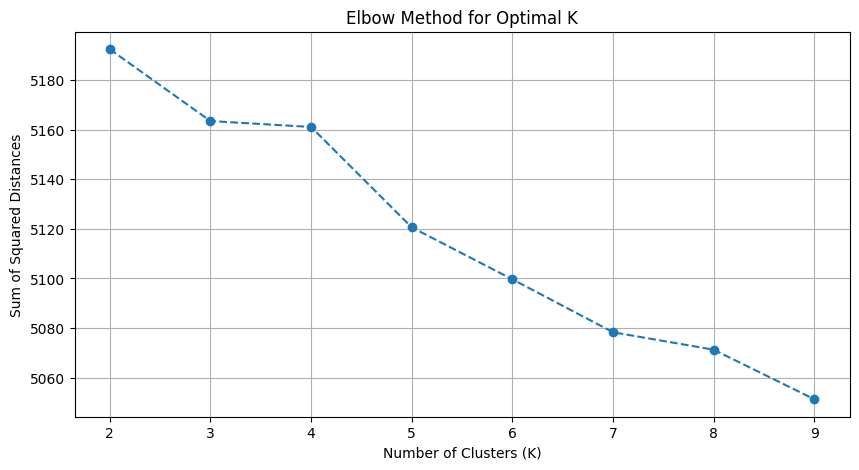

In [5]:
# Finding optimal K using the Elbow Method
sum_of_squared_distances = []
silhouette_scores = []
K_range = range(2, 10)  # Trying different cluster sizes

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_tfidf)
    sum_of_squared_distances.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(10, 5))
plt.plot(K_range, sum_of_squared_distances, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Sum of Squared Distances")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()


In [6]:
optimal_k = 7
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_tfidf)


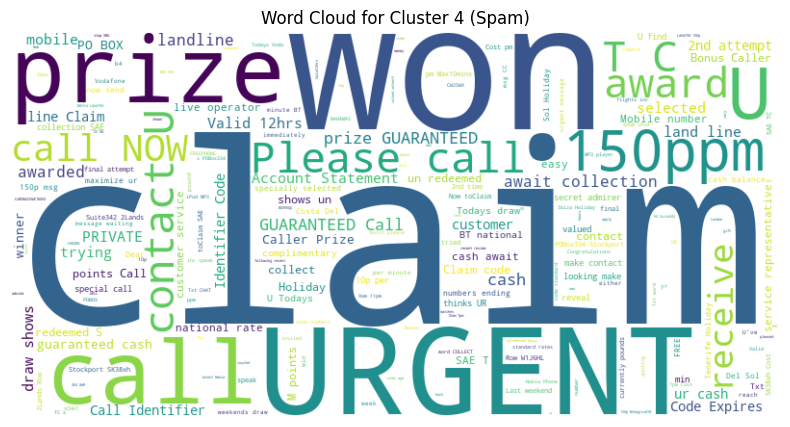

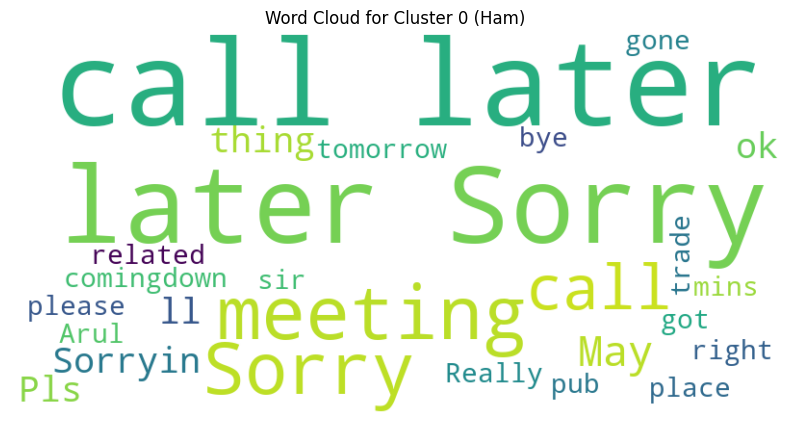

In [7]:
def generate_wordcloud(cluster_num, df, vectorizer, name):
    """Generate and display a word cloud for a specific cluster."""
    cluster_msgs = df[df["cluster"] == cluster_num]["msg"]
    text = " ".join(cluster_msgs)
    
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Cluster {cluster_num} ({name})")
    plt.savefig(f"cluster_{cluster_num}_wordcloud.png", dpi=300)
    plt.show()

# Choose clusters with mostly spam and mostly ham messages
spam_cluster = df.groupby("cluster")["type_encoded"].mean().idxmax()
ham_cluster = df.groupby("cluster")["type_encoded"].mean().idxmin()

# Generate word clouds
generate_wordcloud(spam_cluster, df, vectorizer, "Spam")
generate_wordcloud(ham_cluster, df, vectorizer, "Ham")


In [8]:
spam_messages = df[df["cluster"] == spam_cluster]["msg"].tolist()
ham_messages = df[df["cluster"] == ham_cluster]["msg"].tolist()

print("Spam Messages:")
for msg in spam_messages[:3]:
    print(msg)
    print("-" * 70)

print("\nHam Messages:")
for msg in ham_messages[:3]:
    print(msg)
    print("-" * 70)



Spam Messages:
WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
----------------------------------------------------------------------
URGENT! You have won a 1 week FREE membership in our £100000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18
----------------------------------------------------------------------
As a valued customer I am pleased to advise you that following recent review of your Mob No. you are awarded with a £1500 Bonus Prize call 09066364589
----------------------------------------------------------------------

Ham Messages:
Sorry I'll call later in meeting.
----------------------------------------------------------------------
Sorry I'll call later
----------------------------------------------------------------------
Sorry I'll call later
----------------------------------------------------------------------


In [9]:
# Total size of each cluster
spam_cluster_size = len(df[df['cluster'] == spam_cluster])
ham_cluster_size = len(df[df['cluster'] == ham_cluster])

print(f"Spam Cluster Size: {spam_cluster_size}")
print(f"Ham Cluster Size: {ham_cluster_size}")

# Spam percentage in spam cluster
spam_percentage_in_spam_cluster = df[df['cluster'] == spam_cluster]['type_encoded'].mean() * 100
# Spam percentage in ham cluster
spam_percentage_in_ham_cluster = df[df['cluster'] == ham_cluster]['type_encoded'].mean() * 100

print(f"Percentage of Spam in Spam Cluster: {spam_percentage_in_spam_cluster:.2f}%")
print(f"Percentage of Spam in Ham Cluster: {spam_percentage_in_ham_cluster:.2f}%")

Spam Cluster Size: 193
Ham Cluster Size: 51
Percentage of Spam in Spam Cluster: 98.96%
Percentage of Spam in Ham Cluster: 0.00%


In [10]:
# Find outliers
spam_in_ham_cluster = df[(df["cluster"] == ham_cluster) & (df["type_encoded"] == 1)]
ham_in_spam_cluster = df[(df["cluster"] == spam_cluster) & (df["type_encoded"] == 0)]

# Print example outliers safely
print("Spam messages wrongly clustered with ham:")
if not spam_in_ham_cluster.empty:
    print(spam_in_ham_cluster.sample(min(3, len(spam_in_ham_cluster)))["msg"].tolist())
else:
    print("No spam messages found in the ham cluster.")

print("\nHam messages wrongly clustered with spam:")
if not ham_in_spam_cluster.empty:
    print(ham_in_spam_cluster.sample(min(3, len(ham_in_spam_cluster)))["msg"].tolist())
else:
    print("No ham messages found in the spam cluster.")


Spam messages wrongly clustered with ham:
No spam messages found in the ham cluster.

Ham messages wrongly clustered with spam:
["These won't do. Have to move on to morphine", 'K.:)do it at evening da:)urgent:)']


In [11]:
# Group the dataset by clusters and calculate the mean of 'type_encoded' (0 for ham, 1 for spam)
cluster_labels = df.groupby('cluster')['type_encoded'].mean()

# Print the cluster means
print("Cluster Mean Labels (higher mean corresponds to more spam):")
print(cluster_labels)

Cluster Mean Labels (higher mean corresponds to more spam):
cluster
0    0.000000
1    0.049606
2    0.000000
3    0.006944
4    0.989637
5    0.805085
6    0.005208
Name: type_encoded, dtype: float64


In [12]:
new_messages = [
    "Congratulations! You won a free trip to Vegas. Call now!",
    "Hey, are we meeting for lunch today?",
    "URGENT! Your warranty is about to expire. Call us!",
    "Good morning! Hope you have a great day!"
]   

# Convert new messages to TF-IDF format
new_X_tfidf = vectorizer.transform(new_messages)

# Predict cluster
predicted_clusters = kmeans.predict(new_X_tfidf)

# Compute the distances of new messages to each cluster center
distances = np.linalg.norm(kmeans.cluster_centers_ - new_X_tfidf.toarray()[:, np.newaxis], axis=2)

# Find the minimum distance to the cluster centers
min_distances = np.min(distances, axis=1)

# Print results
for i, msg in enumerate(new_messages):
    predicted_cluster = predicted_clusters[i]
    closest_cluster_distance = min_distances[i]
    
    print(f"Message: '{msg}'")
    print(f"Predicted Cluster: {predicted_cluster}")
    print(f"Distance to Closest Cluster Center: {closest_cluster_distance:.4f}")
    print("-" * 50)



Message: 'Congratulations! You won a free trip to Vegas. Call now!'
Predicted Cluster: 5
Distance to Closest Cluster Center: 0.9844
--------------------------------------------------
Message: 'Hey, are we meeting for lunch today?'
Predicted Cluster: 1
Distance to Closest Cluster Center: 0.9934
--------------------------------------------------
Message: 'URGENT! Your warranty is about to expire. Call us!'
Predicted Cluster: 4
Distance to Closest Cluster Center: 1.0014
--------------------------------------------------
Message: 'Good morning! Hope you have a great day!'
Predicted Cluster: 1
Distance to Closest Cluster Center: 0.9851
--------------------------------------------------


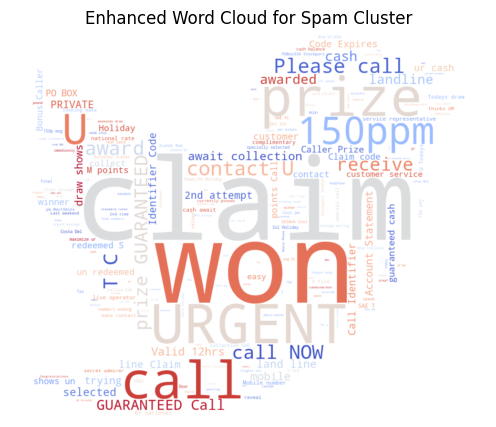

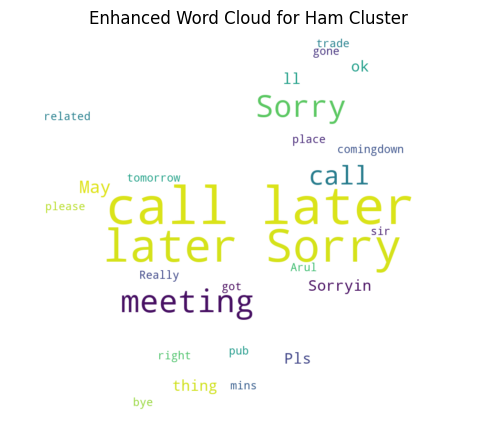

In [13]:
from PIL import Image
import numpy as np

# Load a mask image (e.g., a cloud shape) I will use the twitter logo for my mask
mask = np.array(Image.open("mask.png"))

# Generate a fancy word cloud for spam cluster
wordcloud_spam = WordCloud(width=800, height=400, background_color="white",
                           colormap="coolwarm", mask=mask).generate(
                           " ".join(df[df["cluster"] == spam_cluster]["msg"]))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_spam, interpolation="bilinear")
plt.axis("off")
plt.title(f"Enhanced Word Cloud for Spam Cluster")
plt.savefig("spam_wordcloud.png", dpi=300)
plt.show()

# Generate another word cloud for ham cluster
wordcloud_ham = WordCloud(width=800, height=400, background_color="white",
                          colormap="viridis", mask=mask).generate(
                          " ".join(df[df["cluster"] == ham_cluster]["msg"]))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_ham, interpolation="bilinear")
plt.axis("off")
plt.title(f"Enhanced Word Cloud for Ham Cluster")
plt.savefig("ham_wordcloud.png", dpi=300)
plt.show()


---

In [14]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import plotly.express as px

# Load dataset
url = "https://raw.githubusercontent.com/sziccardi/CSCI4521_DataRepository/refs/heads/main/sms_spam_cleaned.csv"
df = pd.read_csv(url)

# Encode labels ('ham' -> 0, 'spam' -> 1)
label_encoder = LabelEncoder()
df['type_encoded'] = label_encoder.fit_transform(df['type'])

# Vectorize messages using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = vectorizer.fit_transform(df['msg'])


In [15]:
# Apply PCA and reduce dimensions to 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Add the PCA components to the dataframe for plotting
df['PCA1'], df['PCA2'], df['PCA3'] = X_pca[:, 0], X_pca[:, 1], X_pca[:, 2]


In [16]:
# Create an interactive 3D scatter plot
# it should show the document id when you hover over a data point
fig = px.scatter_3d(df, x='PCA1', y='PCA2', z='PCA3', color='type_encoded', hover_data=['msg'])


# Show the plot
fig.show()


In [17]:
# Find the distance of each data point from the origin (principal components)
df['distance_from_origin'] = np.linalg.norm(X_pca, axis=1)

# Identify outliers - spam messages far away from other spam messages
spam_df = df[df['type_encoded'] == 1]
outliers = spam_df[spam_df['distance_from_origin'] > spam_df['distance_from_origin'].quantile(0.95)]

# Display examples of outlier spam messages
outliers_sample = outliers.sample(3)[['msg', 'PCA1', 'PCA2', 'PCA3', 'distance_from_origin']]
print(outliers_sample)


                                                    msg      PCA1      PCA2  \
4826  Do you want a New Nokia 3510i colour phone Del... -0.045053 -0.037751   
2391  U have won a nokia 6230 plus a free digital ca... -0.037865 -0.034197   
5     FreeMsg Hey there darling it's been 3 week's n...  0.140062 -0.023965   

          PCA3  distance_from_origin  
4826 -0.096680              0.113146  
2391 -0.097261              0.109831  
5    -0.053716              0.151912  


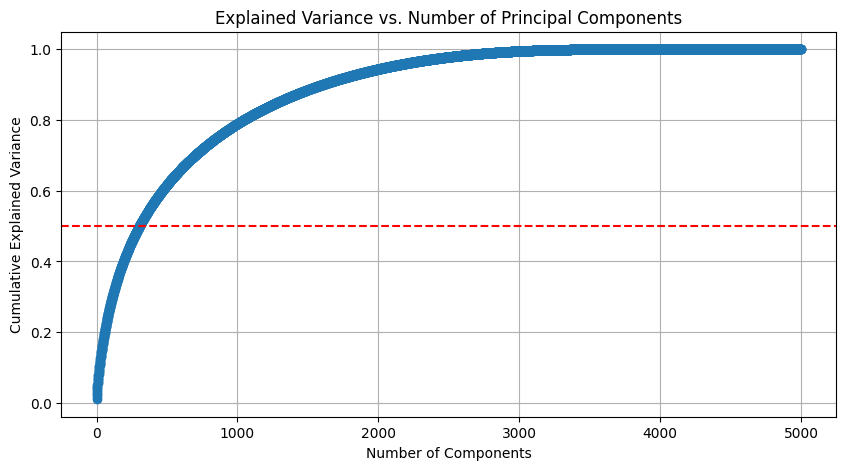

Number of components needed to capture >50% variance: 306


In [29]:
# Apply PCA to reduce dimensionality
pca = PCA()
X_pca = pca.fit_transform(X_tfidf.toarray())

# Plot explained variance to choose the number of components
import matplotlib.pyplot as plt
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--')
plt.axhline(y=0.5, color='r', linestyle='--', label="50% Variance Line")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Principal Components")
plt.grid(True)
plt.show()

components_needed_manual = np.argmax(np.cumsum(explained_variance) > 0.5) + 1
print(f"Number of components needed to capture >50% variance: {components_needed_manual}")

---

In [21]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score
import time

# Load dataset
url = "https://raw.githubusercontent.com/sziccardi/CSCI4521_DataRepository/refs/heads/main/sms_spam_cleaned.csv"
df = pd.read_csv(url)

# Encode labels ('ham' -> 0, 'spam' -> 1)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['type_encoded'] = label_encoder.fit_transform(df['type'])

# Vectorize messages using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = vectorizer.fit_transform(df['msg'])
y = df['type_encoded']


In [22]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


In [23]:
# Train 1-NN classifier on full TF-IDF features
knn_full = KNeighborsClassifier(n_neighbors=1)

# Measure runtime
start_time = time.time()
knn_full.fit(X_train, y_train)
runtime_full = time.time() - start_time

# Make predictions
y_pred_full = knn_full.predict(X_test)

# Calculate metrics
accuracy_full = accuracy_score(y_test, y_pred_full)
f1_full = f1_score(y_test, y_pred_full)

print(f"1-NN with Full Features:")
print(f"Runtime: {runtime_full:.4f} seconds")
print(f"Accuracy: {accuracy_full:.4f}")
print(f"F1-Score: {f1_full:.4f}")


1-NN with Full Features:
Runtime: 0.0020 seconds
Accuracy: 0.9152
F1-Score: 0.6980


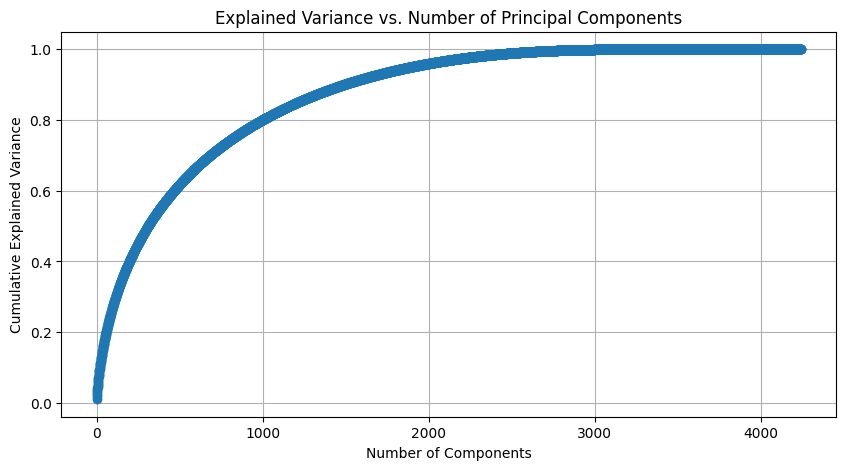

Chosen number of components: 1491


In [24]:
# Apply PCA to reduce dimensionality
pca = PCA()
X_train_pca = pca.fit_transform(X_train.toarray())
X_test_pca = pca.transform(X_test.toarray())

# Plot explained variance to choose the number of components
import matplotlib.pyplot as plt
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Principal Components")
plt.grid(True)
plt.show()

# Choose number of components to explain at least 90% variance
k = np.argmax(np.cumsum(explained_variance) > 0.9) + 1  # Choose k such that 90% variance is explained
print(f"Chosen number of components: {k}")

# Reduce the data to k components
pca = PCA(n_components=k)
X_train_pca = pca.fit_transform(X_train.toarray())
X_test_pca = pca.transform(X_test.toarray())


In [25]:
# Train 1-NN classifier on PCA-reduced features
knn_pca = KNeighborsClassifier(n_neighbors=1)

# Measure runtime
start_time = time.time()
knn_pca.fit(X_train_pca, y_train)
runtime_pca = time.time() - start_time

# Make predictions
y_pred_pca = knn_pca.predict(X_test_pca)

# Calculate metrics
accuracy_pca = accuracy_score(y_test, y_pred_pca)
f1_pca = f1_score(y_test, y_pred_pca)

print(f"\n1-NN with PCA (top-{k} components):")
print(f"Runtime: {runtime_pca:.4f} seconds")
print(f"Accuracy: {accuracy_pca:.4f}")
print(f"F1-Score: {f1_pca:.4f}")
    


1-NN with PCA (top-1491 components):
Runtime: 0.0290 seconds
Accuracy: 0.9491
F1-Score: 0.7857


In [26]:
print("\nComparison of 1-NN Classifiers:")
print(f"Full Features - Runtime: {runtime_full:.4f}s, Accuracy: {accuracy_full:.4f}, F1-Score: {f1_full:.4f}")
print(f"PCA Reduced Features - Runtime: {runtime_pca:.4f}s, Accuracy: {accuracy_pca:.4f}, F1-Score: {f1_pca:.4f}")



Comparison of 1-NN Classifiers:
Full Features - Runtime: 0.0020s, Accuracy: 0.9152, F1-Score: 0.6980
PCA Reduced Features - Runtime: 0.0290s, Accuracy: 0.9491, F1-Score: 0.7857


---

In [27]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# Load dataset
url = "https://raw.githubusercontent.com/sziccardi/CSCI4521_DataRepository/refs/heads/main/sms_spam_cleaned.csv"
df = pd.read_csv(url)

# Encode labels (spam=1, ham=0)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['type_encoded'] = label_encoder.fit_transform(df['type'])

# Initialize Porter Stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Function for text preprocessing
def preprocess_text(text):
    words = text.lower().split()  # Convert to lowercase and tokenize
    words = [stemmer.stem(word) for word in words if word not in stop_words]  # Remove stopwords and stem
    return ' '.join(words)

# Apply preprocessing to messages
df['msg_cleaned'] = df['msg'].apply(preprocess_text)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = vectorizer.fit_transform(df['msg_cleaned'])
y = df['type_encoded']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Apply PCA to find optimal number of components
pca = PCA()
X_train_pca = pca.fit_transform(X_train.toarray())

# Reduce dimensions using PCA
pca = PCA(n_components=k)
X_train_pca = pca.fit_transform(X_train.toarray())
X_test_pca = pca.transform(X_test.toarray())

# Train KNN classifier
knn_pca = KNeighborsClassifier(n_neighbors=1)
start_time = time.time()
knn_pca.fit(X_train_pca, y_train)
runtime_pca = time.time() - start_time

# Predict and evaluate
y_pred_pca = knn_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
f1_pca = f1_score(y_test, y_pred_pca)

# Print results
print("\nKNN with PCA, Stemming & Stopword Removal:")
print(f"Runtime: {runtime_pca:.4f} seconds")
print(f"Accuracy: {accuracy_pca:.4f}")
print(f"F1-Score: {f1_pca:.4f}")


KNN with PCA, Stemming & Stopword Removal:
Runtime: 0.0227 seconds
Accuracy: 0.9434
F1-Score: 0.7600


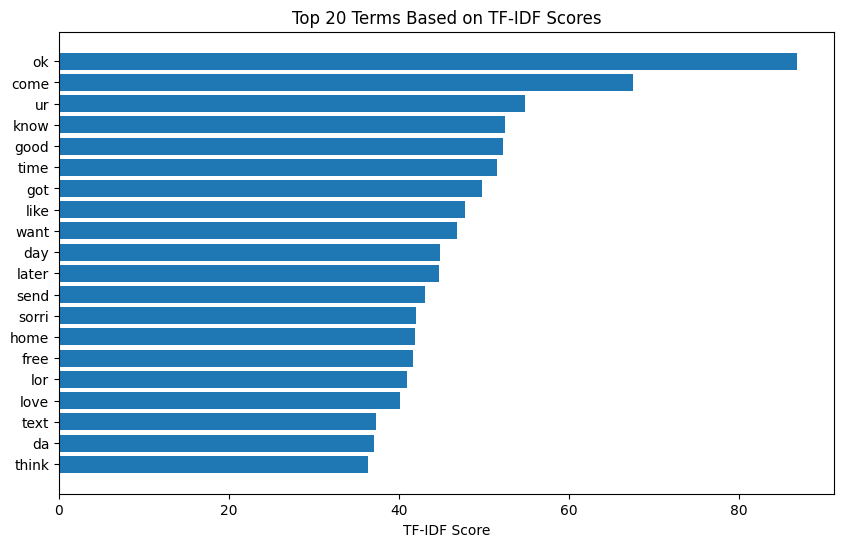

In [28]:
import matplotlib.pyplot as plt

# Get the most frequent words and their TF-IDF scores
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_scores = np.asarray(X_train.sum(axis=0)).flatten()
top_n = 20  # Show the top 20 words

# Get the indices of the top N words
top_indices = np.argsort(tfidf_scores)[-top_n:]

# Plot the top N words
plt.figure(figsize=(10, 6))
plt.barh(np.array(tfidf_feature_names)[top_indices], tfidf_scores[top_indices])
plt.xlabel('TF-IDF Score')
plt.title(f"Top {top_n} Terms Based on TF-IDF Scores")
plt.show()
